# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from collections import deque
import random
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent # Agent taken from https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py

In [8]:
hyperparams = {
    'buffer_size' : int(1e6),  # replay buffer size
    'batch_size' : 512,        # minibatch size
    'gamma' : 0.99,            # discount factor
    'tau' : 2e-1,              # for soft update of target parameters
    'lr_actor' : 1e-4,         # learning rate of the actor 
    'lr_critic' : 3e-4,        # learning rate of the critic
    'weight_decay' : 0.0000   # L2 weight decay
}

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, hyperparams=hyperparams)

/home/vtrudel/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


- 0.0832662582397461 seconds -
Episode 1	Average Score: 0.00
Score for this episode: [-0.01  0.  ]
- 0.07387495040893555 seconds -
Episode 2	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.05125999450683594 seconds -
Episode 3	Average Score: 0.00
Score for this episode: [-0.01  0.  ]
- 0.06105852127075195 seconds -
Episode 4	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.0795142650604248 seconds -
Episode 5	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.09105372428894043 seconds -
Episode 6	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.09120440483093262 seconds -
Episode 7	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.09017157554626465 seconds -
Episode 8	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.05657458305358887 seconds -
Episode 9	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.05853915214538574 seconds -
Episode 10	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
-

- 0.5114874839782715 seconds -
Episode 84	Average Score: 0.03
Score for this episode: [ 0.   -0.01]
- 1.220628261566162 seconds -
Episode 85	Average Score: 0.03
Score for this episode: [-0.01  0.1 ]
- 1.4177448749542236 seconds -
Episode 86	Average Score: 0.03
Score for this episode: [-0.01  0.1 ]
- 1.1893277168273926 seconds -
Episode 87	Average Score: 0.03
Score for this episode: [-0.01  0.  ]
- 1.4084663391113281 seconds -
Episode 88	Average Score: 0.03
Score for this episode: [ 0.1  -0.01]
- 3.1759727001190186 seconds -
Episode 89	Average Score: 0.04
Score for this episode: [0.09 0.2 ]
- 1.7706491947174072 seconds -
Episode 90	Average Score: 0.04
Score for this episode: [ 0.1  -0.01]
- 0.6057326793670654 seconds -
Episode 91	Average Score: 0.04
Score for this episode: [ 0.   -0.01]
- 0.5695090293884277 seconds -
Episode 92	Average Score: 0.04
Score for this episode: [-0.01  0.  ]
- 1.9412281513214111 seconds -
Episode 93	Average Score: 0.04
Score for this episode: [-0.01  0.1 ]
- 0

- 0.5279655456542969 seconds -
Episode 166	Average Score: 0.08
Score for this episode: [-0.01  0.  ]
- 0.5731997489929199 seconds -
Episode 167	Average Score: 0.08
Score for this episode: [ 0.   -0.01]
- 2.0854883193969727 seconds -
Episode 168	Average Score: 0.08
Score for this episode: [0.09 0.1 ]
- 1.2084622383117676 seconds -
Episode 169	Average Score: 0.08
Score for this episode: [ 0.1  -0.01]
- 1.2859725952148438 seconds -
Episode 170	Average Score: 0.08
Score for this episode: [ 0.1  -0.01]
- 2.076694965362549 seconds -
Episode 171	Average Score: 0.08
Score for this episode: [0.09 0.1 ]
- 1.2109041213989258 seconds -
Episode 172	Average Score: 0.08
Score for this episode: [ 0.1  -0.01]
- 2.149256944656372 seconds -
Episode 173	Average Score: 0.08
Score for this episode: [0.1  0.09]
- 0.654508113861084 seconds -
Episode 174	Average Score: 0.08
Score for this episode: [ 0.   -0.01]
- 0.5702781677246094 seconds -
Episode 175	Average Score: 0.08
Score for this episode: [ 0.   -0.01]

- 2.0360312461853027 seconds -
Episode 248	Average Score: 0.10
Score for this episode: [-0.01  0.1 ]
- 4.093688249588013 seconds -
Episode 249	Average Score: 0.10
Score for this episode: [0.2  0.19]
- 2.109123468399048 seconds -
Episode 250	Average Score: 0.10
Score for this episode: [0.1  0.09]
- 0.8148646354675293 seconds -
Episode 251	Average Score: 0.10
Score for this episode: [-0.01  0.  ]
- 2.104768991470337 seconds -
Episode 252	Average Score: 0.10
Score for this episode: [0.09 0.1 ]
- 2.563605785369873 seconds -
Episode 253	Average Score: 0.10
Score for this episode: [0.09 0.2 ]
- 2.0917956829071045 seconds -
Episode 254	Average Score: 0.10
Score for this episode: [0.09 0.1 ]
- 2.103477716445923 seconds -
Episode 255	Average Score: 0.10
Score for this episode: [0.09 0.1 ]
- 1.3779447078704834 seconds -
Episode 256	Average Score: 0.10
Score for this episode: [-0.01  0.1 ]
- 2.8236141204833984 seconds -
Episode 257	Average Score: 0.10
Score for this episode: [0.2  0.09]
- 2.08644

- 1.6364591121673584 seconds -
Episode 331	Average Score: 0.14
Score for this episode: [0.1  0.09]
- 2.336632490158081 seconds -
Episode 332	Average Score: 0.15
Score for this episode: [0.2  0.09]
- 2.7711892127990723 seconds -
Episode 333	Average Score: 0.15
Score for this episode: [0.2  0.09]
- 1.0238547325134277 seconds -
Episode 334	Average Score: 0.15
Score for this episode: [-0.01  0.  ]
- 1.2364811897277832 seconds -
Episode 335	Average Score: 0.15
Score for this episode: [ 0.1  -0.01]
- 2.742759943008423 seconds -
Episode 336	Average Score: 0.15
Score for this episode: [0.2  0.09]
- 2.911890745162964 seconds -
Episode 337	Average Score: 0.15
Score for this episode: [0.09 0.2 ]
- 5.106662034988403 seconds -
Episode 338	Average Score: 0.15
Score for this episode: [0.19 0.2 ]
- 0.5835957527160645 seconds -
Episode 339	Average Score: 0.15
Score for this episode: [-0.01  0.  ]
- 2.9111452102661133 seconds -
Episode 340	Average Score: 0.15
Score for this episode: [0.2  0.09]
- 2.7727

- 5.711218357086182 seconds -
Episode 413	Average Score: 0.21
Score for this episode: [0.29 0.3 ]
- 1.271329641342163 seconds -
Episode 414	Average Score: 0.21
Score for this episode: [ 0.   -0.01]
- 1.984661340713501 seconds -
Episode 415	Average Score: 0.21
Score for this episode: [-0.01  0.1 ]
- 5.264511346817017 seconds -
Episode 416	Average Score: 0.21
Score for this episode: [0.19 0.3 ]
- 0.5479283332824707 seconds -
Episode 417	Average Score: 0.21
Score for this episode: [-0.01  0.  ]
- 5.326470375061035 seconds -
Episode 418	Average Score: 0.21
Score for this episode: [0.29 0.3 ]
- 13.141163110733032 seconds -
Episode 419	Average Score: 0.22
Score for this episode: [0.79000001 0.80000001]
- 6.786955833435059 seconds -
Episode 420	Average Score: 0.22
Score for this episode: [0.39000001 0.40000001]
- 1.3649871349334717 seconds -
Episode 421	Average Score: 0.22
Score for this episode: [-0.01  0.1 ]
- 10.571533918380737 seconds -
Episode 422	Average Score: 0.22
Score for this episo

- 2.5021212100982666 seconds -
Episode 491	Average Score: 0.65
Score for this episode: [0.1  0.09]
- 2.0921428203582764 seconds -
Episode 492	Average Score: 0.65
Score for this episode: [0.1  0.09]
- 1.3018033504486084 seconds -
Episode 493	Average Score: 0.65
Score for this episode: [-0.01  0.1 ]
- 2.757368326187134 seconds -
Episode 494	Average Score: 0.66
Score for this episode: [0.1  0.19]
- 1.5309562683105469 seconds -
Episode 495	Average Score: 0.65
Score for this episode: [ 0.1  -0.01]
- 35.16138005256653 seconds -
Episode 496	Average Score: 0.67
Score for this episode: [2.10000003 1.99000003]
- 16.50071883201599 seconds -
Episode 497	Average Score: 0.67
Score for this episode: [0.79000001 0.90000001]
- 4.34874701499939 seconds -
Episode 498	Average Score: 0.67
Score for this episode: [0.2  0.19]
- 2.77097225189209 seconds -
Episode 499	Average Score: 0.67
Score for this episode: [0.1  0.09]
- 3.4763500690460205 seconds -
Episode 500	Average Score: 0.67
Score for this episode: [

- 6.303559064865112 seconds -
Episode 570	Average Score: 0.90
Score for this episode: [0.3        0.39000001]
- 27.81924057006836 seconds -
Episode 571	Average Score: 0.89
Score for this episode: [1.59000002 1.60000002]
- 26.590861082077026 seconds -
Episode 572	Average Score: 0.90
Score for this episode: [1.60000002 1.59000002]
- 44.67855978012085 seconds -
Episode 573	Average Score: 0.93
Score for this episode: [2.60000004 2.60000004]
- 23.652309894561768 seconds -
Episode 574	Average Score: 0.94
Score for this episode: [1.29000002 1.40000002]
- 44.99462842941284 seconds -
Episode 575	Average Score: 0.97
Score for this episode: [2.60000004 2.50000004]
- 5.385416269302368 seconds -
Episode 576	Average Score: 0.97
Score for this episode: [0.3  0.29]
- 1.3605437278747559 seconds -
Episode 577	Average Score: 0.97
Score for this episode: [ 0.1  -0.01]
- 36.730199337005615 seconds -
Episode 578	Average Score: 0.99
Score for this episode: [2.09000003 2.10000003]
- 45.37845063209534 seconds 

- 45.9435088634491 seconds -
Episode 648	Average Score: 1.47
Score for this episode: [2.60000004 2.60000004]
- 12.492835998535156 seconds -
Episode 649	Average Score: 1.45
Score for this episode: [0.80000001 0.59000001]
- 46.720683097839355 seconds -
Episode 650	Average Score: 1.47
Score for this episode: [2.60000004 2.60000004]
- 41.99219083786011 seconds -
Episode 651	Average Score: 1.50
Score for this episode: [2.60000004 2.60000004]
- 46.456013441085815 seconds -
Episode 652	Average Score: 1.50
Score for this episode: [2.60000004 2.70000004]
- 0.8762571811676025 seconds -
Episode 653	Average Score: 1.47
Score for this episode: [ 0.1  -0.01]
- 2.1438043117523193 seconds -
Episode 654	Average Score: 1.45
Score for this episode: [ 0.1  -0.01]
- 2.8596367835998535 seconds -
Episode 655	Average Score: 1.43
Score for this episode: [0.2  0.09]
- 47.16915321350098 seconds -
Episode 656	Average Score: 1.45
Score for this episode: [2.60000004 2.60000004]
- 47.28618407249451 seconds -
Episode

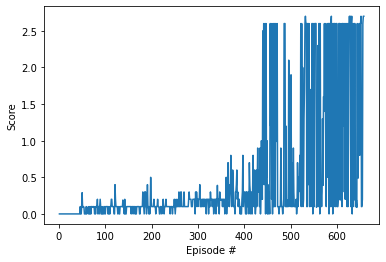

In [10]:
def maddpg(n_episodes=100000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_history = []
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment  
        agent.reset()
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = [agent.act(s, add_noise=False) for s in states]
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            for n in range(num_agents):
                agent.step(states[n], actions[n], rewards[n], next_states[n], dones[n]) 
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        scores_deque.append(np.max(scores))
        scores_history.append(np.max(scores))
        print("- %s seconds -" % (time.time() - start_time))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        print('Score for this episode: {}'.format(scores))
    
        if np.mean(scores_deque) > 1.5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rSOLVED!!  Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        
    return scores_history

scores = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [11]:
agents = [Agent(state_size=state_size, action_size=action_size, hyperparams=hyperparams) for n in range(num_agents)]
for n in range(num_agents):
    agents[n].actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
    agents[n].critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [12]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = [agents[n].act(states[n], add_noise=False) for n in range(num_agents)]
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    for n in range(num_agents):
        agents[n].step(states[n], actions[n], rewards[n], next_states[n], dones[n]) 
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

/home/vtrudel/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score (averaged over agents) this episode: 1.7450000261887908
